In [1]:
import os
import yaml

from lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, matthews_corrcoef, confusion_matrix, roc_auc_score
import torch
import torch_geometric
from torch_geometric.nn import global_max_pool
import umap


from virtual_screening import VirtualScreeningEmbedder, VirtualScreener, ClassicalVirtualScreener
from dataset import VirtualScreeningDataModule
from model import PharmacoMatch
from utils import load_model_from_path, enrichment_factor, bootstrap_metric, bedroc_score, PcaEmbeddingPlotter, UmapEmbeddingPlotter

umap.plot.output_notebook()

/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/flash/__init__.py:21: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):


Loading BokehJS ...

In [2]:
# Define global variables
PROJECT_ROOT = '/data/shared/projects/PhectorDB'
PRETRAINING_ROOT = f"{PROJECT_ROOT}/training_data"
DATASET_ROOT = f"{PROJECT_ROOT}/DUDE-Z"
TARGET = "UROK"
VS_ROOT = f"{DATASET_ROOT}/{TARGET}"
MODEL = PharmacoMatch
VS_MODEL_NUMBER = 250
MODEL_PATH = f"{PROJECT_ROOT}/logs/{MODEL.__name__}/version_{VS_MODEL_NUMBER}/"
HPARAMS_FILE = "hparams.yaml"

params = yaml.load(
    open(os.path.join(PROJECT_ROOT, MODEL_PATH, HPARAMS_FILE), "r"), Loader=yaml.FullLoader
)

# Deterministic flags (should not be necessary for inference, but just in case)
torch.set_float32_matmul_precision("medium")
torch_geometric.seed_everything(params["seed"])
seed_everything(params["seed"])
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Setup datamodule
datamodule = VirtualScreeningDataModule(
    VS_ROOT,
    batch_size=params["batch_size"],
)
datamodule.setup()

# Load the model
model = load_model_from_path(os.path.join(PROJECT_ROOT, MODEL_PATH), MODEL)
trainer = Trainer(
    num_nodes=1,
    devices=[0],
    max_epochs=params["epochs"],
    accelerator="auto",
    logger=False,
    log_every_n_steps=2,
)

# Create embeddings of the VS dataset
embedder = VirtualScreeningEmbedder(model, datamodule, trainer)
screener = VirtualScreener(embedder)
classical_screener = ClassicalVirtualScreener(datamodule)

experiment_data = dict()
experiment_data['target'] = TARGET
experiment_data['model'] = VS_MODEL_NUMBER
experiment_data['embedding_time'] = screener.embedding_time
experiment_data['matching_time'] = screener.matching_time
experiment_data['query_num_features'] = datamodule.metadata.query['num_features'].sum()
experiment_data['active_ligands'] = torch.max(screener.active_mol_ids).item() + 1
experiment_data['inactive_ligands'] = torch.max(screener.inactive_mol_ids).item() + 1
experiment_data['active_conformations'] = len(screener.active_mol_ids)
experiment_data['inactive_conformations'] = len(screener.inactive_mol_ids)

Seed set to 42


Number of query graphs: 1
Number of active graphs: 1467
Number of inactive graphs: 74747


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]
/data/shared/software/conda/daniel_rose/envs/ph4/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Predicting: |          | 0/? [00:00<?, ?it/s]

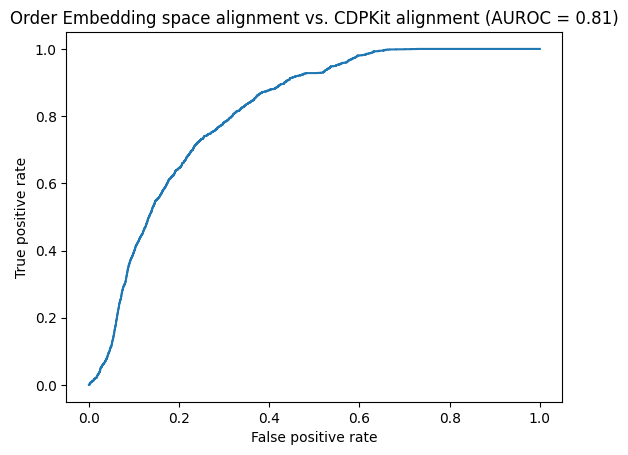

According to the ROC curve, the best threshold is 6.455704689025879.
----------------------------
This yields an MCC of 0.18175965067765174.
AUROC = 0.8107816060468713.
Confusion matrix:
[[45806 27794]
 [  351  2263]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.23894466905294381.
Confusion matrix:
[[2585 1717]
 [  23  235]]


In [4]:
# Determine optimal threshold via ROC curve
y_true = classical_screener.matches
y_pred = -screener.conformation_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]
y_pred = screener.conformation_score <= best_threshold

plt.plot(fpr, tpr)
plt.title(f"Order Embedding space alignment vs. CDPKit alignment (AUROC = {auroc:.2f})")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()
        
print(f"According to the ROC curve, the best threshold is {best_threshold}.")
print("----------------------------")
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print(f"AUROC = {auroc}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("----------------------------")
print("Aggregation of conformational ensembles into one result per molecule:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

experiment_data['auroc_comparison'] = auroc

In [4]:
# bootrstrapping
y_true = classical_screener.matches
y_pred = -screener.conformation_score
auroc_mean, auroc_std = bootstrap_metric(y_true, y_pred, roc_auc_score, 100)

In [5]:
# Feature Count baseline - We need to get better than this
print("--- Feature count baseline for inactive ligands ---")
y_true = classical_screener.matches
y_pred = screener.prefilter_mask
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nAfter aggregation of the conformational ensembles:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"MCC: {matthews_corrcoef(y_true, y_pred)}")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

--- Feature count baseline for inactive ligands ---
MCC: 0.20511889151272586
Confusion matrix:
[[45859 27741]
 [  188  2426]]

After aggregation of the conformational ensembles:
MCC: 0.29920900648196
Confusion matrix:
[[2966 1336]
 [  19  239]]


In [6]:
# We can also combine the prefilter with the order embedding alignment
y_true = classical_screener.matches
y_pred = -screener.conformation_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
j = tpr - fpr
idx = np.argmax(j)
best_threshold = -threshold[idx]
y_pred = screener.conformation_score <= best_threshold
y_pred = y_pred * screener.prefilter_mask 

print(f"According to the ROC curve, the best threshold is {best_threshold}.")
print("----------------------------")
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print(f"AUROC = {auroc}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

print("----------------------------")
print("Aggregation of conformational ensembles into one result per molecule:")
y_true = global_max_pool(y_true, screener.mol_ids)
y_pred = global_max_pool(y_pred, screener.mol_ids)
print(f"This yields an MCC of {matthews_corrcoef(y_true, y_pred)}.")
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))

According to the ROC curve, the best threshold is 6.455721378326416.
----------------------------
This yields an MCC of 0.22544681002946268.
AUROC = 0.8107814994926981.
Confusion matrix:
[[52111 21489]
 [  351  2263]]
----------------------------
Aggregation of conformational ensembles into one result per molecule:
This yields an MCC of 0.312982915505404.
Confusion matrix:
[[3094 1208]
 [  23  235]]


The enrichment factor at 0.005 is 0.0.
The enrichment factor at 0.01 is 0.0.
The enrichment factor at 0.05 is 0.25641024112701416.
----------------------------
The enrichment factor at 0.005 is 35.897438049316406.
The enrichment factor at 0.01 is 26.923078536987305.
The enrichment factor at 0.05 is 12.820512771606445.
----------------------------


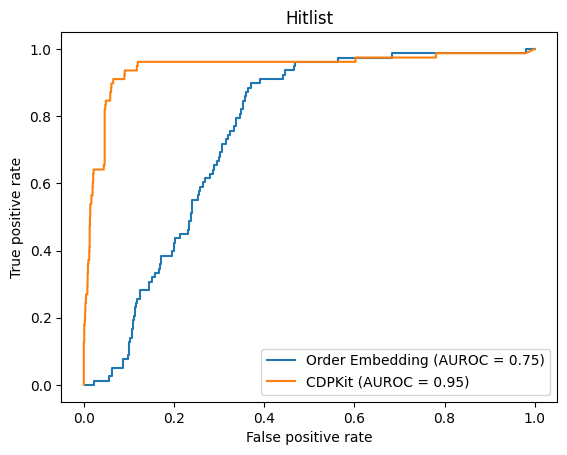

In [7]:
# Hitlist with the order embedding algorithm
y_true = screener.ligand_label
y_pred = -screener.ligand_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc = roc_auc_score(y_true, y_pred)
bedroc = bedroc_score(y_true, y_pred)
experiment_data['order_embedding_auroc'] = auroc


fig = plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
alphas = [0.005, 0.01, 0.05]
for alpha in alphas:    
    enrichment = enrichment_factor(y_true, y_pred, alpha).item()
    print(f"The enrichment factor at {alpha} is {enrichment}.")
    experiment_data[f'order_embedding_ef{alpha}'] = enrichment
print("----------------------------")

# Hitlist with the CDPKit alignment
y_true = screener.ligand_label
y_pred = global_max_pool(classical_screener.alignment_score, screener.mol_ids)

#path="matching.png"  
fpr, tpr, threshold = roc_curve(y_true, y_pred)
auroc_cdp = roc_auc_score(y_true, y_pred)
bedroc_cdp = bedroc_score(y_true, y_pred)
experiment_data['cdpkit_auroc'] = auroc_cdp

plt.plot(fpr, tpr)
plt.title(f"Hitlist")
plt.legend([f"Order Embedding (AUROC = {auroc:.2f})", f"CDPKit (AUROC = {auroc_cdp:.2f})"])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

alphas = [0.005, 0.01, 0.05]
for alpha in alphas:    
    enrichment = enrichment_factor(y_true, y_pred, alpha).item()
    print(f"The enrichment factor at {alpha} is {enrichment}.")
    experiment_data[f'cdpkit_ef{alpha}'] = enrichment
print("----------------------------")

plt.show()

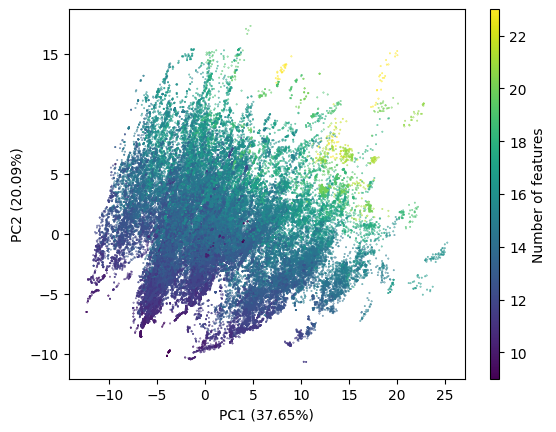

In [8]:
pca_plotter = PcaEmbeddingPlotter(screener, datamodule.metadata)
fig3 = pca_plotter.create_pca_plot()
fig3.show()

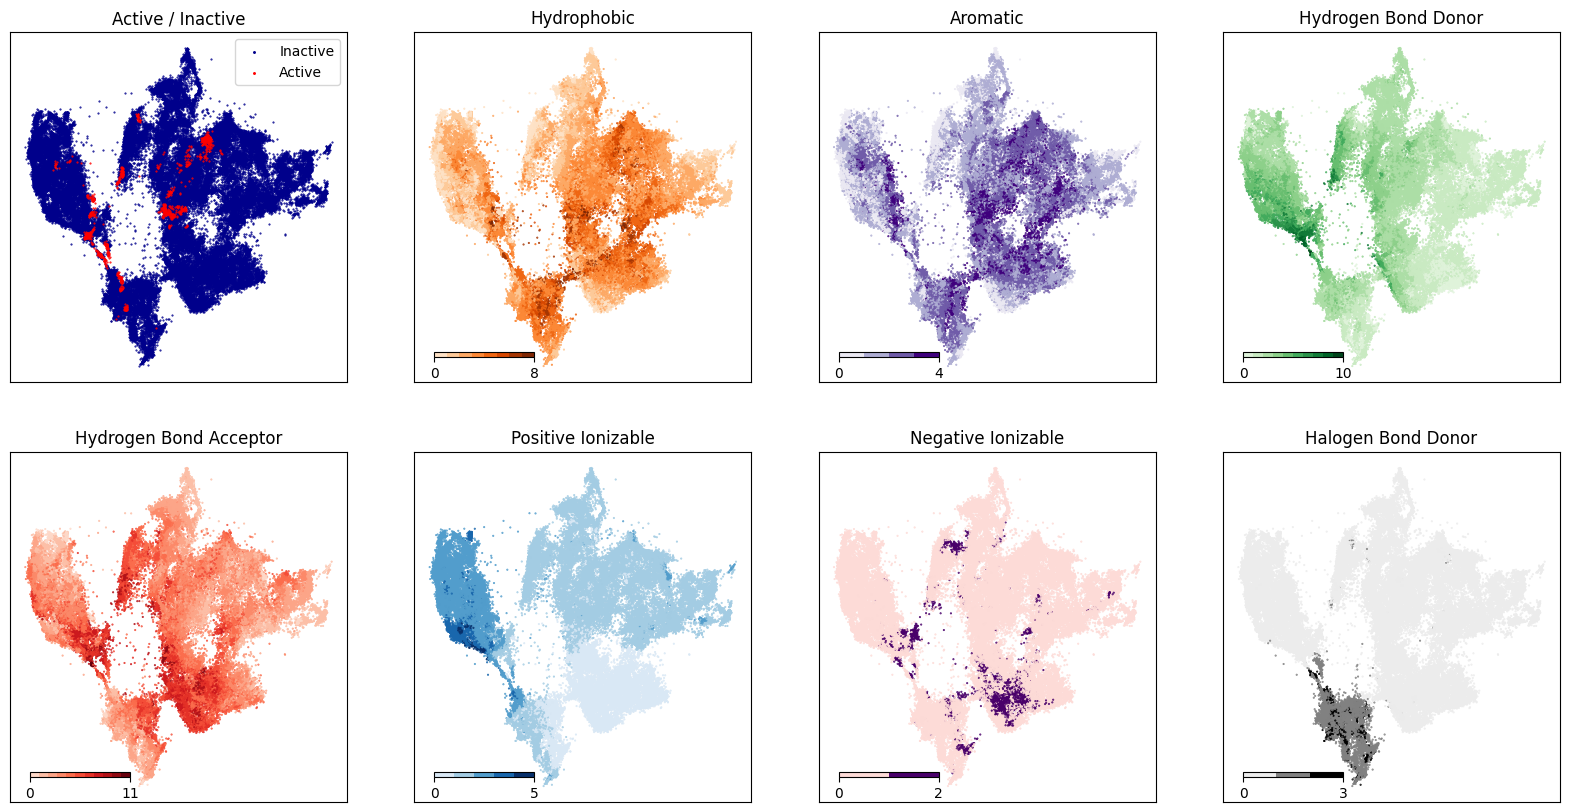

In [9]:
umap_plotter = UmapEmbeddingPlotter(screener, datamodule.metadata)
fig4 = umap_plotter.create_umap_plot()
fig4.savefig(
    f"visualization/embeddings_{TARGET}.png",
    dpi=300,
    bbox_inches="tight",
)

In [10]:
p = umap_plotter.create_interactive_umap_by_feature_type("HBD")
umap.plot.show(p)